### Two circuits implementing Boolean AB + AC 

In [1]:
import numpy as np
%matplotlib widget
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import itertools
from functools import reduce
from scipy.stats import entropy
from itertools import product

In [2]:
def joint_state_space(state_spaces):
    return np.array([joint_state for joint_state in product(*state_spaces)])

def state_index(state, space):
    return np.where(space==state)[0]

def state_indices(coords_dict, mstate, msubset, jstate_spc):
    '''
    inputs:
        mstate: (arr) representing state of a subset of all the coordinates involved in jstate_spc
        msubset: (arr) representing which coordinates, out of the ones involved in jstate_spc, are in the subset
        jstate_spc: (arr of arr) containing all joint states from which we want to pluck. At a minimum it contains the
            coordinates in msubset.
    outputs:
        (arr) of indices in jstate_spc corresponding to where the msubset takes on the state mstate
    '''
    if len(msubset) > 1:
        return reduce(np.intersect1d, [np.where(jstate_spc[:,coords_dict[sub]]==mstate[i])[0] for i,sub in enumerate(msubset)])
    else:
        return reduce(np.intersect1d, [np.where(jstate_spc[:,coords_dict[sub]]==mstate)[0] for i,sub in enumerate(msubset)])

def get_marginal(coords_dict, subset, marg_spc, joint_spc, joint_pdist):
    '''
    inputs:
        subset: (arr) representing which coordinates, out of the ones involved in joint_spc, are in the subset
        marg_spc: (arr of arr) of all joint states of subset
        joint_spc: (arr of arr) containing all joint states from which we want to pluck. At a minimum it contains the
            coordinates in subset
        joint_pdist: (arr) joint probability distribution of joint_spc
    outputs:
        (arr) marginal probability distribution of the subset of coordinates
    '''
    return np.array([np.sum(np.take(joint_pdist, state_indices(coords_dict, ms, subset, joint_spc))) for ms in marg_spc])

def L1(p1, p2):
    return sum([np.abs(a-b) for a,b in zip(p1,p2)])

def SLT(typ, L, Atot):
    if typ == 'shiraishi':
        out = (L**2)/(2*Atot)
    elif typ == 'pinsker':
        out = 2*(L**2)/(Atot)
    elif typ == 'skld':
        if L/Atot < 1:
            out = 2*L*np.arctanh(L/Atot)
        else:
            out = 0
    else:
        out = 'Error'
    return np.round(out, 5)

def input_correlation(corr, s1, s2):
        #s1 depends on s2:
        if s1 == s2:
            return 0.5 + corr
        else:
            return 0.5 - corr
        
def output_correlation_and(corr, s1, s2, s3):
    if s3 == s1*s2:
        return 0.5 + corr
    else:
        return 0.5 - corr

def output_correlation_or(corr, s1, s2, s3):
    if s3 == s1 | s2:
        return 0.5 + corr
    else:
        return 0.5 - corr
        
def delta0(s1, s2, s3):
    return (s3==0)

def AND(s1, s2, s3, a):
    if s3 == s1*s2:
        return a
    else:
        return 1-a

def OR(s1, s2, s3, a):
    if s3 == s1 | s2:
        return a
    else:
        return 1-a

### Mismatch cost for two circuits implementing Boolean AB + AC 

In [7]:
# AND-AND-OR

def ckt1(c, a):
    
    X_A = np.arange(2)
    X_B = np.arange(2)
    X_C = np.arange(2)
    X_AB = np.arange(2)
    X_AC = np.arange(2)
    X_AB_AC = np.arange(2)

    coords = {
        'A': 0,
        'B': 1,
        'C': 2,
        'AB': 3,
        'AC': 4,
        'AB_AC': 5,
    }

    coords_spaces = {
        'A': X_A,
        'B': X_B,
        'C': X_C,
        'AB': X_AB,
        'AC': X_AC,
        'AB_AC': X_AB_AC,
    }

    X = joint_state_space([X_A, X_B, X_C, X_AB, X_AC, X_AB_AC])
    numstates = X.shape[0]
    
    
    def joint_from_conditionals(p_AgivB, p_BgivC, p_C, p_ABgivA_B, p_ACgivA_C, p_ABAC_givAB_AC):
        p = np.zeros((numstates,))
        
        for i, x in enumerate(X):
            xA = x[coords['A']]
            xB = x[coords['B']]
            xC = x[coords['C']]
            xAB = x[coords['AB']]
            xAC = x[coords['AC']]
            xABAC = x[coords['AB_AC']]
            iA = state_index(x[coords['A']], coords_spaces['A'])
            iB = state_index(x[coords['B']], coords_spaces['B'])
            iC = state_index(x[coords['C']], coords_spaces['C'])
            iAB = state_index(x[coords['AB']], coords_spaces['AB'])
            iAC = state_index(x[coords['AC']], coords_spaces['AC'])
            iABAC = state_index(x[coords['AB_AC']], coords_spaces['AB_AC'])
            p[i] = p_AgivB[iB,iA]*p_BgivC[iC,iB]*p_C[iC]*p_ABgivA_B[iA,iB,iAB]*p_ACgivA_C[iA,iC,iAC]*p_ABAC_givAB_AC[iAB,iAC,iABAC]
        
        return p
    

    '''
    Initialization
    '''

    p_AgivB_0 = np.array([input_correlation(0, xA, xB) for xA, xB in product(X_A,X_B)]).reshape((2,2))
    p_BgivC_0 = np.array([input_correlation(0, xB, xC) for xB, xC in product(X_B,X_C)]).reshape((2,2))
    p_C_0 = np.array([0.5 for xC in X_C])    
    p_ABgivA_B_0 = np.array([delta0(xA, xB, xAB) for xA, xB, xAB in product(X_A,X_B,X_AB)]).reshape((2,2,2))
    p_ACgivA_C_0 = np.array([delta0(xA, xC, xAC) for xA, xC, xAC in product(X_A,X_C,X_AC)]).reshape((2,2,2))
    p_ABAC_givAB_AC_0 = np.array([delta0(xAB, xAC, xABAC) for xAB, xAC, xABAC in product(X_AB,X_AC,X_AB_AC)]).reshape((2,2,2))
    p_ABgivA_B_0 = np.array([output_correlation_and(0.5*c, xA, xB, xAB) for xA, xB, xAB in product(X_A,X_B,X_AB)]).reshape((2,2,2))
    p_ACgivA_C_0 = np.array([output_correlation_and(0.5*c, xA, xC, xAC) for xA, xC, xAC in product(X_A,X_C,X_AC)]).reshape((2,2,2))
    p_ABAC_givAB_AC_0 = np.array([output_correlation_or(0.5*c, xAB, xAC, xABAC) for xAB, xAC, xABAC in product(X_AB,X_AC,X_AB_AC)]).reshape((2,2,2))
    p_0 = joint_from_conditionals(p_AgivB_0, p_BgivC_0, p_C_0, p_ABgivA_B_0, p_ACgivA_C_0, p_ABAC_givAB_AC_0)
    
    p_AB_0 = get_marginal(coords, ['AB'], X_AB, X, p_0)
    p_AC_0 = get_marginal(coords, ['AC'], X_AC, X, p_0)
    p_AB_AC_0 = get_marginal(coords, ['AB_AC'], X_AB_AC, X, p_0)
    
    q_AgivB_0 = np.array([input_correlation(0, xA, xB) for xA, xB in product(X_A,X_B)]).reshape((2,2))
    q_BgivC_0 = np.array([input_correlation(0, xB, xC) for xB, xC in product(X_B,X_C)]).reshape((2,2))
    q_C_0 = np.array([0.5 for xC in X_C])    
    q_ABgivA_B_0 = np.array([p_AB_0[xAB] for xA, xB, xAB in product(X_A,X_B,X_AB)]).reshape((2,2,2))
    q_ACgivA_C_0 = np.array([p_AC_0[xAC] for xA, xC, xAC in product(X_A,X_C,X_AC)]).reshape((2,2,2))
    q_ABAC_givAB_AC_0 = np.array([p_AB_AC_0[xABAC] for xAB, xAC, xABAC in product(X_AB,X_AC,X_AB_AC)]).reshape((2,2,2))
#     q_ABgivA_B_0 = np.array([0.5 for xA, xB, xAB in product(X_A,X_B,X_AB)]).reshape((2,2,2))
#     q_ACgivA_C_0 = np.array([0.5 for xA, xC, xAC in product(X_A,X_C,X_AC)]).reshape((2,2,2))
#     q_ABAC_givAB_AC_0 = np.array([0.5 for xAB, xAC, xABAC in product(X_AB,X_AC,X_AB_AC)]).reshape((2,2,2))
    q_0 = joint_from_conditionals(q_AgivB_0, q_BgivC_0, q_C_0, q_ABgivA_B_0, q_ACgivA_C_0, q_ABAC_givAB_AC_0)
    
#     print(joint_state_space([X_A, X_B, X_C]))
#     print(get_marginal(coords, ['A', 'B', 'C'], joint_state_space([X_A, X_B, X_C]), X, p_0))
#     print(get_marginal(coords, ['A'], X_A, X, p_0))
#     print()
#     print(get_marginal(coords, ['A', 'B', 'C'], joint_state_space([X_A, X_B, X_C]), X, q_0))
#     print(get_marginal(coords, ['A'], X_A, X, q_0))
    

    '''
    Step 1
    '''
    
    p_ABgivA_B_1 = np.array([AND(xA, xB, xAB, a) for xA, xB, xAB in product(X_A,X_B,X_AB)]).reshape((2,2,2))
    p_1 = joint_from_conditionals(p_AgivB_0, p_BgivC_0, p_C_0, p_ABgivA_B_1, p_ACgivA_C_0, p_ABAC_givAB_AC_0)
    
    q_ABgivA_B_1 = np.copy(p_ABgivA_B_1)
    q_1 = joint_from_conditionals(q_AgivB_0, q_BgivC_0, q_C_0, q_ABgivA_B_1, q_ACgivA_C_0, q_ABAC_givAB_AC_0)


    '''
    Step 2
    '''

    p_ACgivA_C_2 = np.array([AND(xA, xC, xAC, a) for xA, xC, xAC in product(X_A,X_C,X_AC)]).reshape((2,2,2))
    p_2 = joint_from_conditionals(p_AgivB_0, p_BgivC_0, p_C_0, p_ABgivA_B_1, p_ACgivA_C_2, p_ABAC_givAB_AC_0)
    
    q_ACgivA_C_2 = np.copy(p_ACgivA_C_2)
    q_2 = joint_from_conditionals(q_AgivB_0, q_BgivC_0, q_C_0, q_ABgivA_B_1, q_ACgivA_C_2, q_ABAC_givAB_AC_0)


    '''
    Step 3
    '''

    p_ABAC_givAB_AC_3 = np.array([OR(xAB, xAC, xABAC, a) for xAB, xAC, xABAC in product(X_AB,X_AC,X_AB_AC)]).reshape((2,2,2))
    p_f = joint_from_conditionals(p_AgivB_0, p_BgivC_0, p_C_0, p_ABgivA_B_1, p_ACgivA_C_2, p_ABAC_givAB_AC_3)


    q_ABAC_givAB_AC_3 = np.copy(p_ABAC_givAB_AC_3)
    q_f = joint_from_conditionals(q_AgivB_0, q_BgivC_0, q_C_0, q_ABgivA_B_1, q_ACgivA_C_2, q_ABAC_givAB_AC_3)
    
    
    '''
    Mismatch Cost
    '''
    
    MMC = entropy(p_0, q_0) - entropy(p_f, q_f)

    return MMC

In [8]:
print(ckt1(0.7, 1))

print(ckt1(1, 1))

0.6859966812192582
1.7862335273955987


In [10]:
# OR-AND

def ckt2(c, a):
    
    X_A = np.arange(2)
    X_B = np.arange(2)
    X_C = np.arange(2)
    X_B_C = np.arange(2)
    X_AB_AC = np.arange(2)

    coords = {
        'A': 0,
        'B': 1,
        'C': 2,
        'B_C': 3,
        'AB_AC': 4,
    }

    coords_spaces = {
        'A': X_A,
        'B': X_B,
        'C': X_C,
        'B_C': X_B_C,
        'AB_AC': X_AB_AC,
    }

    X = joint_state_space([X_A, X_B, X_C, X_B_C, X_AB_AC])
    numstates = X.shape[0]

    def joint_from_conditionals(p_AgivB, p_BgivC, p_C, p_BCgivB_C, p_ABAC_givA_BC):
        p = np.zeros((numstates,))
        
        for i, x in enumerate(X):
            xA = x[coords['A']]
            xB = x[coords['B']]
            xC = x[coords['C']]
            xBC = x[coords['B_C']]
            xABAC = x[coords['AB_AC']]
            iA = state_index(x[coords['A']], coords_spaces['A'])
            iB = state_index(x[coords['B']], coords_spaces['B'])
            iC = state_index(x[coords['C']], coords_spaces['C'])
            iBC = state_index(x[coords['B_C']], coords_spaces['B_C'])
            iABAC = state_index(x[coords['AB_AC']], coords_spaces['AB_AC'])
            p[i] = p_AgivB[iB,iA]*p_BgivC[iC,iB]*p_C[iC]*p_BCgivB_C[iB,iC,iBC]*p_ABAC_givA_BC[iA,iBC,iABAC]
        
        return p
    
    
    '''
    Initialization
    '''

    p_AgivB_0 = np.array([input_correlation(0, xA, xB) for xA, xB in product(X_A,X_B)]).reshape((2,2))
    p_BgivC_0 = np.array([input_correlation(0, xB, xC) for xB, xC in product(X_B,X_C)]).reshape((2,2))
    p_C_0 = np.array([0.5 for xC in X_C])    
    p_BCgivB_C_0 = np.array([output_correlation_or(0.5*c, xB, xC, xBC) for xB, xC, xBC in product(X_B,X_C,X_B_C)]).reshape((2,2,2))
    p_ABAC_givA_BC_0 = np.array([output_correlation_and(0.5*c, xA, xBC, xABAC) for xA, xBC, xABAC in product(X_A,X_B_C,X_AB_AC)]).reshape((2,2,2))
    p_0 = joint_from_conditionals(p_AgivB_0, p_BgivC_0, p_C_0, p_BCgivB_C_0, p_ABAC_givA_BC_0)
    
    p_B_C_0 = get_marginal(coords, ['B_C'], X_B_C, X, p_0)
    p_AB_AC_0 = get_marginal(coords, ['AB_AC'], X_AB_AC, X, p_0)
    
    q_AgivB_0 = np.array([input_correlation(0, xA, xB) for xA, xB in product(X_A,X_B)]).reshape((2,2))
    q_BgivC_0 = np.array([input_correlation(0, xB, xC) for xB, xC in product(X_B,X_C)]).reshape((2,2))
    q_C_0 = np.array([0.5 for xC in X_C])    
    q_BCgivB_C_0 = np.array([p_B_C_0[xBC] for xB, xC, xBC in product(X_B,X_C,X_B_C)]).reshape((2,2,2))
    q_ABAC_givA_BC_0 = np.array([p_AB_AC_0[xABAC] for xA, xBC, xABAC in product(X_A,X_B_C,X_AB_AC)]).reshape((2,2,2))
#     q_BCgivB_C_0 = np.array([0.5 for xB, xC, xBC in product(X_B,X_C,X_B_C)]).reshape((2,2,2))
#     q_ABAC_givA_BC_0 = np.array([0.5 for xA, xBC, xABAC in product(X_A,X_B_C,X_AB_AC)]).reshape((2,2,2))
    q_0 = joint_from_conditionals(q_AgivB_0, q_BgivC_0, q_C_0, q_BCgivB_C_0, q_ABAC_givA_BC_0)


    '''
    Step 1
    '''
    
    p_BCgivB_C_1 = np.array([OR(xB, xC, xBC, a) for xB, xC, xBC in product(X_B,X_C,X_B_C)]).reshape((2,2,2))
    p_1 = joint_from_conditionals(p_AgivB_0, p_BgivC_0, p_C_0, p_BCgivB_C_1, p_ABAC_givA_BC_0)
    
    q_BCgivB_C_1 = np.copy(p_BCgivB_C_1)
    q_1 = joint_from_conditionals(q_AgivB_0, q_BgivC_0, q_C_0, q_BCgivB_C_1, q_ABAC_givA_BC_0)


    '''
    Step 2
    '''

    p_ABAC_givA_BC_2 = np.array([AND(xA, xBC, xABAC, a) for xA, xBC, xABAC in product(X_A,X_B_C,X_AB_AC)]).reshape((2,2,2))
    p_f = joint_from_conditionals(p_AgivB_0, p_BgivC_0, p_C_0, p_BCgivB_C_1, p_ABAC_givA_BC_2)
    
    
    q_ABAC_givA_BC_2 = np.copy(p_ABAC_givA_BC_2)
    q_f = joint_from_conditionals(q_AgivB_0, q_BgivC_0, q_C_0, q_BCgivB_C_1, q_ABAC_givA_BC_2)
    
    
    '''
    Mismatch Cost
    '''
    
    MMC = entropy(p_0, q_0) - entropy(p_f, q_f)
    
#     print(p_0)
#     print(q_0)
#     print()
#     print(p_f)
#     print(q_f)
            
    return MMC

In [11]:
print(ckt2(0.7, 1))

print(ckt2(1, 1))

0.4522039288063191
1.2238983827767904


In [12]:
clist = np.linspace(0,1,1001)
ckt1_list = np.array([np.array(ckt1(c, 1)) for c in clist])
ckt2_list = np.array([np.array(ckt2(c, 1)) for c in clist])

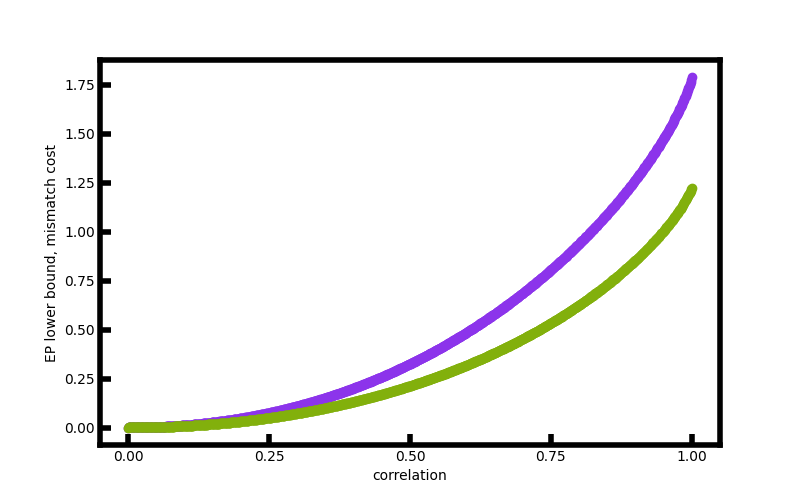

In [16]:
# creating figure
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(clist, ckt1_list, c='#8c34eb')  
ax.scatter(clist, ckt2_list, c='#82b00c') 

ax.set_xlabel('correlation')
ax.set_ylabel('EP lower bound, mismatch cost')
# ax.set_ylim([-0.1,1.1])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
# ax.set_xticks([0,0.2,0.4,0.6])
ax.tick_params(direction = 'in', length = 8, width = 4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
# ax.legend()